In [ ]:
#!pip install contextily

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Dense
from tensorflow.keras.optimizers import Adam
from shapely.geometry import Point
import geopandas as gpd

# Load the data from CSV file
data = pd.read_csv(r"./Daily_HAI_Mean.csv")

# Preprocess the data
# Assuming you have latitude, longitude, and activity_index columns
# Convert date to datetime format
data['date'] = pd.to_datetime(data['ds'])
# Normalize latitude and longitude
data['latitude_norm'] = (data['Lat'] - data['Lat'].min()) / (data['Lat'].max() - data['Lat'].min())
data['longitude_norm'] = (data['Lon'] - data['Lon'].min()) / (data['Lon'].max() - data['Lon'].min())
data['activity_index'] = (data['y'] - data['y'].min()) / (data['y'].max() - data['y'].min())

# Define parameters
seq_length = 5  # Length of sequence for each sample
n_features = 3  # Number of features (latitude, longitude, activity_index)
n_filters = 128  # Number of filters in ConvLSTM layers
kernel_size = (1, 1)  # Kernel size for ConvLSTM layers (adjusted based on spatial dimensions)

# Prepare the data for ConvLSTM
X = []
y = []
for i in range(len(data) - seq_length):
    X.append(data[['latitude_norm', 'longitude_norm', 'activity_index']].iloc[i:i+seq_length].values)
    y.append(data['activity_index'].iloc[i+seq_length])
X = np.array(X)
y = np.array(y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the data for ConvLSTM
X_train = X_train.reshape(-1, seq_length, 1, n_features, 1)
X_test = X_test.reshape(-1, seq_length, 1, n_features, 1)

# Build the ConvLSTM model
model = Sequential([
    ConvLSTM2D(filters=n_filters, kernel_size=kernel_size, activation='relu', input_shape=(seq_length, 1, n_features, 1)),
    Dense(1)  # Output layer
])

# Compile the model
model.compile(optimizer=Adam(), loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))




Epoch 1/50
18/18 [==============================] - 2s 18ms/step - loss: 0.1448 - val_loss: 0.0780
Epoch 2/50
18/18 [==============================] - 0s 5ms/step - loss: 0.0493 - val_loss: 0.0374
Epoch 3/50
18/18 [==============================] - 0s 5ms/step - loss: 0.0377 - val_loss: 0.0378
Epoch 4/50
18/18 [==============================] - 0s 5ms/step - loss: 0.0362 - val_loss: 0.0346
Epoch 5/50
18/18 [==============================] - 0s 5ms/step - loss: 0.0355 - val_loss: 0.0332
Epoch 6/50
18/18 [==============================] - 0s 5ms/step - loss: 0.0349 - val_loss: 0.0366
Epoch 7/50
18/18 [==============================] - 0s 5ms/step - loss: 0.0337 - val_loss: 0.0319
Epoch 8/50
18/18 [==============================] - 0s 5ms/step - loss: 0.0343 - val_loss: 0.0325
Epoch 9/50
18/18 [==============================] - 0s 5ms/step - loss: 0.0335 - val_loss: 0.0341
Epoch 10/50
18/18 [==============================] - 0s 5ms/step - loss: 0.0332 - val_loss: 0.0315
Epoch 11/50
18/18 

3/3 [==============================] - 0s 7ms/step - loss: 0.0323
Test Loss: 0.03232144936919212
3/3 [==============================] - 0s 2ms/step


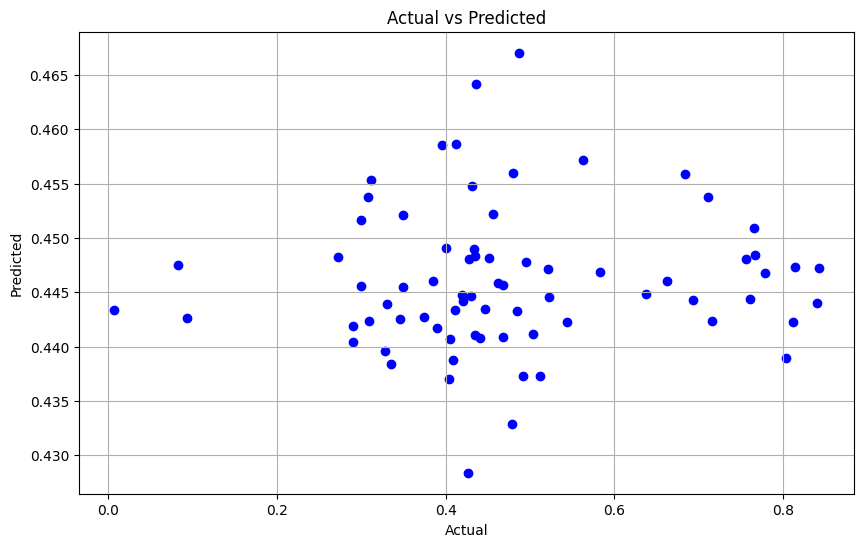

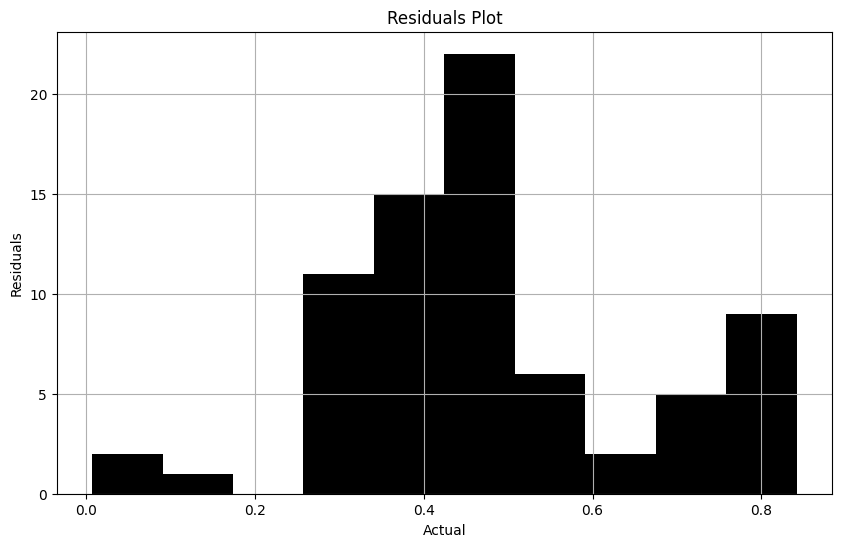

Mean Squared Error: 0.03218652489250188
R-squared: -0.027052350592394303


C:\Users\User\anaconda3\envs\python38\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\User\AppData\Local\Temp\ipykernel_10184\1559855565.py:58: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file('test_predicted_values.shp')


In [15]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

# Make predictions
y_pred = model.predict(X_test)

# Reshape predictions and actual labels
y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)

# Ensure both have the same number of samples
min_samples = min(len(y_test), len(y_pred))
y_test = y_test[:min_samples]
y_pred = y_pred[:min_samples]

# Compute evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.hist(y_test, color='blue')
plt.hist(y_test, y_pred, color='blue')
#plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.show()

# Plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, color='black')
#plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.grid(True)
plt.show()

# Print evaluation metrics
print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Combine test data with predicted values
test_df = pd.DataFrame({'Actual_Activity_Index': y_test, 'Predicted_Activity_Index': y_pred,
                        'Latitude': data['Lat'][-len(y_test):][:min_samples],
                        'Longitude': data['Lon'][-len(y_test):][:min_samples]})

# Save test data and predicted values to CSV
test_df.to_csv('test_predicted_values.csv', index=False)

# Convert CSV to shapefile
geometry = [Point(xy) for xy in zip(test_df['Longitude'], test_df['Latitude'])]
gdf = gpd.GeoDataFrame(test_df, geometry=geometry)
gdf.crs = {'init': 'epsg:4326'}  # Assuming WGS84 coordinate reference system
gdf.to_file('test_predicted_values.shp')

In [8]:
print(gdf.columns)


Index(['Actual_Activity_Index', 'Predicted_Activity_Index', 'Latitude',
       'Longitude', 'geometry'],
      dtype='object')


Index(['Actual_Act', 'Predicted_', 'Latitude', 'Longitude', 'geometry'], dtype='object')


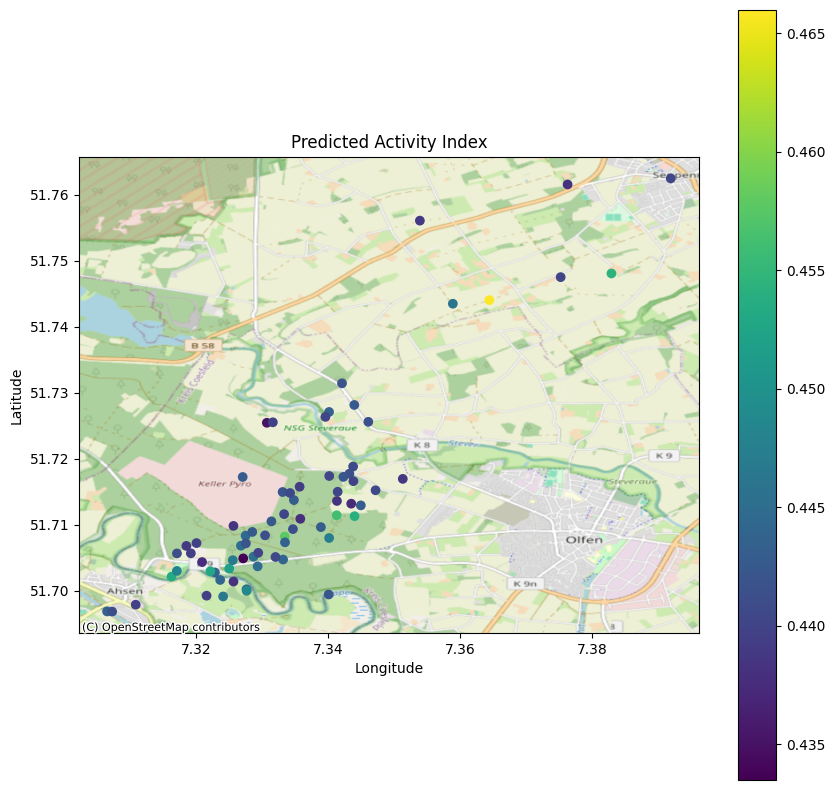

In [9]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# Read the shapefile
gdf = gpd.read_file('test_predicted_values.shp')

# Check the columns in the GeoDataFrame
print(gdf.columns)

# Plot the shapefile with OpenStreetMap (OSM) as the basemap
fig, ax = plt.subplots(figsize=(10, 10))
if 'Predicted_' in gdf.columns:
    gdf.plot(ax=ax, column='Predicted_', legend=True)

# Add OpenStreetMap (OSM) basemap
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

plt.title('Predicted Activity Index')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [ ]:
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(results_df)


In [ ]:
X_test.shape, y_pred.shape

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Dense
from tensorflow.keras.optimizers import Adam

# Load the data from CSV file
data = pd.read_csv(r"C:\Users\janak\ConvLSTM\Daily_HAI_Mean.csv")

# Preprocess the data
# Assuming you have latitude, longitude, and activity_index columns
# Convert date to datetime format
data['date'] = pd.to_datetime(data['ds'])
# Normalize latitude and longitude
data['latitude'] = (data['Lat'] - data['Lat'].min()) / (data['Lat'].max() - data['Lat'].min())
data['longitude'] = (data['Lon'] - data['Lon'].min()) / (data['Lon'].max() - data['Lon'].min())
data['activity_index'] = (data['y'] - data['y'].min()) / (data['y'].max() - data['y'].min())

# Define parameters
seq_length = 7  # Length of sequence for each sample
n_features = 3  # Number of features (latitude, longitude, activity_index)
n_filters = 32  # Number of filters in ConvLSTM layers
kernel_size = (1, 1)  # Kernel size for ConvLSTM layers (adjusted based on spatial dimensions)

# Prepare the data for ConvLSTM
X = []
y = []
for i in range(len(data) - seq_length):
    X.append(data[['latitude', 'longitude', 'activity_index']].iloc[i:i+seq_length].values)
    y.append(data['activity_index'].iloc[i+seq_length])
X = np.array(X)
y = np.array(y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the data for ConvLSTM
X_train = X_train.reshape(-1, seq_length, 1, n_features, 1)
X_test = X_test.reshape(-1, seq_length, 1, n_features, 1)

# Build the ConvLSTM model
model = Sequential([
    ConvLSTM2D(filters=n_filters, kernel_size=kernel_size, activation='relu', input_shape=(seq_length, 1, n_features, 1)),
    Dense(1)  # Output layer
])

# Compile the model
model.compile(optimizer=Adam(), loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Assuming you already have the model trained and the test data prepared
# model = trained model
# X_test = test features
# y_test = actual test labels

# Make predictions
y_pred = model.predict(X_test)

# Reshape predictions and actual labels
y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)

# Ensure both have the same number of samples
min_samples = min(len(y_test), len(y_pred))
y_test = y_test[:min_samples]
y_pred = y_pred[:min_samples]

# Compute evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Plot actual vs predicted
plt.figure(figsize=(8, 4))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.show()

# Plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(8, 4))
plt.scatter(y_test, residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.grid(True)
plt.show()

# Print evaluation metrics
print("Mean Squared Error:", mse)
print("R-squared:", r2)
